In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from skimage.color import rgb2lab, lab2rgb
from matplotlib import patches as patch
from skimage import measure
from mpl_toolkits.mplot3d import Axes3D
import math
import tqdm
from numpy.linalg import inv, det
import scipy as sp
import seaborn as sns
%matplotlib inline

https://stackoverflow.com/questions/28342968/how-to-plot-a-2d-gaussian-with-different-sigma/28343236

https://towardsdatascience.com/simple-example-of-2d-density-plots-in-python-83b83b934f67

https://zhiyzuo.github.io/EM/

In [2]:
def objects(path):
    object  = os.listdir(path)
    return object

name = objects(path = "./Banana/")

def dataset_loader(datatype, imagetype):
    def loadImages(path = "./Banana/" +str(datatype)+"/"):

        return[os.path.join(path,f) for f in os.listdir(path) if f.endswith(imagetype)]

    filenames = loadImages()
    images = []
    for file in filenames:
        image = cv2.imread(file)
        image = cv2.resize(image, (100,100))
        images.append((image[:,:,::-1])/255)

    return images

In [3]:
class GMM(object):
    def __init__(self, X, k=2):
        # dimension
        X = np.asarray(X)
        self.m, self.n = X.shape
        self.data = X.copy()
        # number of mixtures
        self.k = k
        
    def _init(self):
        # init mixture means/sigmas
        self.mean_arr = np.asmatrix(np.random.random((self.k, self.n)))
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.w = np.asmatrix(np.empty((self.m, self.k), dtype=float))
        #print(self.mean_arr)
        #print(self.sigma_arr)
    
    def fit(self, tol=1e-4):
        self._init()
        num_iters = 0
        ll = 1
        previous_ll = 0
        while(ll-previous_ll > tol):
            previous_ll = self.loglikelihood()
            self._fit()
            num_iters += 1
            ll = self.loglikelihood()
            print('Iteration %d: log-likelihood is %.6f'%(num_iters, ll))
        print('Terminate at %d-th iteration:log-likelihood is %.6f'%(num_iters, ll))
    
    def loglikelihood(self):
        ll = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                #print(self.sigma_arr[j])
                tmp += sp.stats.multivariate_normal.pdf(self.data[i, :], 
                                                        self.mean_arr[j, :].A1, 
                                                        self.sigma_arr[j, :]) *\
                       self.phi[j]
            ll += np.log(tmp) 
        return ll
    
    def _fit(self):
        self.e_step()
        self.m_step()
        
    def e_step(self):
        # calculate w_j^{(i)}
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = sp.stats.multivariate_normal.pdf(self.data[i, :], 
                                                       self.mean_arr[j].A1, 
                                                       self.sigma_arr[j]) *\
                      self.phi[j]
                den += num
                self.w[i, j] = num
            self.w[i, :] /= den
            assert self.w[i, :].sum() - 1 < 1e-4
            
    def m_step(self):
        for j in range(self.k):
            const = self.w[:, j].sum()
            self.phi[j] = 1/self.m * const
            _mu_j = np.zeros(self.n)
            _sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                _mu_j += (self.data[i, :] * self.w[i, j])
                _sigma_j += self.w[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
                #print((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
            self.mean_arr[j] = _mu_j / const
            self.sigma_arr[j] = _sigma_j / const
        #print(self.sigma_arr)

In [4]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

In [5]:
def LAB_mean(datatype):
    images = dataset_loader(datatype, ".jpg")

    a_ = []
    b_ = []
    hue = []
    for i in range(len(images)):
        img = images[i]#[:,:,::-1]
        lab = rgb2lab(img)
        a,b = lab[:,:,1].ravel(),lab[:,:,2].ravel()
        a_.append(np.mean(a))
        b_.append(np.mean(b))
        h = math.atan2(np.mean(b),np.mean(a)) * 180 / np.pi
        if h < 0:
            h = 360 - np.abs(h)
        hue.append(h)
        

    return a_, b_, hue


def Ecc(datatype):
    images = dataset_loader(datatype, ".jpg")
    E = []
    for i in range(len(images)):
        img = images[i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.bitwise_not(img)
        thresh = 0.05
        img = img/255
        img[img<thresh] = 0
        img[img>thresh] = 1
        A = measure.label(img, neighbors=4)
        for region in measure.regionprops(A,coordinates='xy'):
            E.append(region.eccentricity)
            
    return E

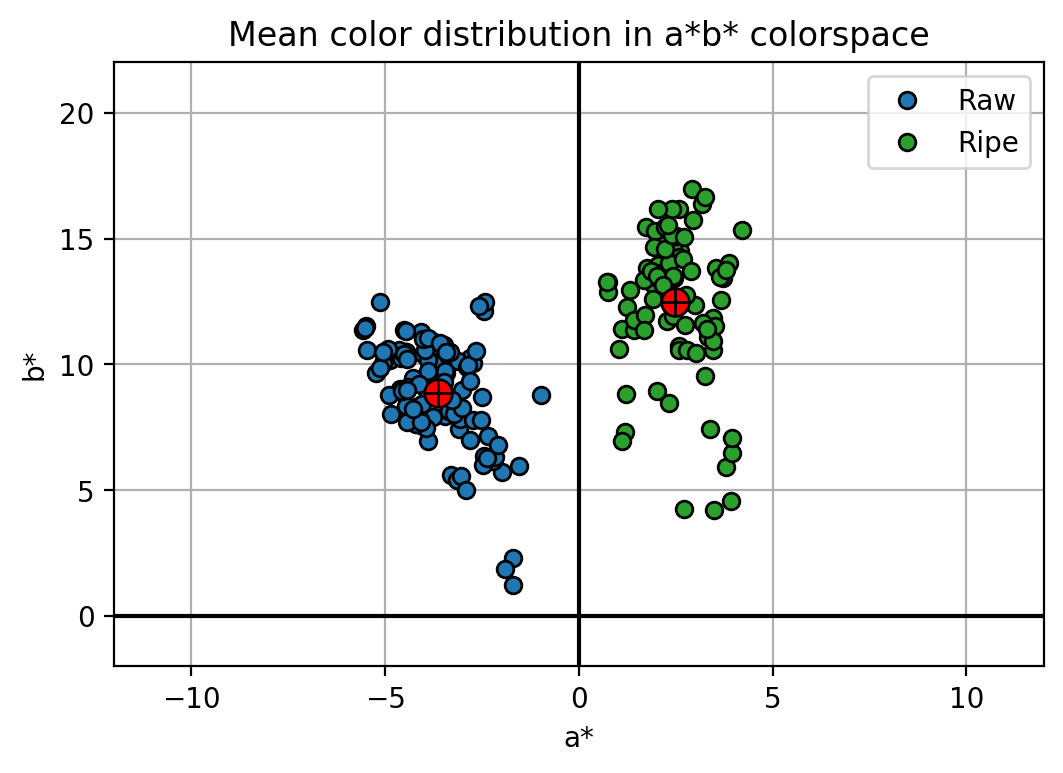

In [6]:
plt.figure(dpi=200)
plt.axhline(0, color = 'k')
plt.axvline(0, color = 'k')

data = np.zeros(shape=[80,2,2])
A,B = [],[]
label_A, label_B = [],[]
mean = np.zeros(shape=[2,2])
COV = np.zeros(shape=[2,2,2])


for i in name:
    classs = name.index(i)
    a_, b_, hue = LAB_mean(i)
    data[:,0, classs] = a_[:80]
    data[:,1, classs] = b_[:80]
    for a in a_: A.append(a)
    for b in b_: B.append(b)

    mean[classs,0] = np.mean(a_)
    mean[classs,1] = np.mean(b_)
    
    COV[:,:,classs] = np.cov(a_,b_)
    plt.plot(a_,b_,'o',ms = 6, mec = 'k', label = i)
    plt.plot(np.mean(a_),np.mean(b_), 'ro', ms= 10, mec = 'k')
    plt.plot(np.mean(a_),np.mean(b_), '+', ms= 10, mec = 'k')

    plt.xlabel("a*")
    plt.ylabel("b*")
    plt.xlim(-12,12)
    plt.ylim(-2,22)
    
plt.legend()
plt.grid()
plt.title("Mean color distribution in a*b* colorspace")

DATA = np.zeros(shape = [192,2])
DATA[:,0],DATA[:,1] = np.array(A),np.array(B)

C:\Users\Rene\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


(-8, 8)

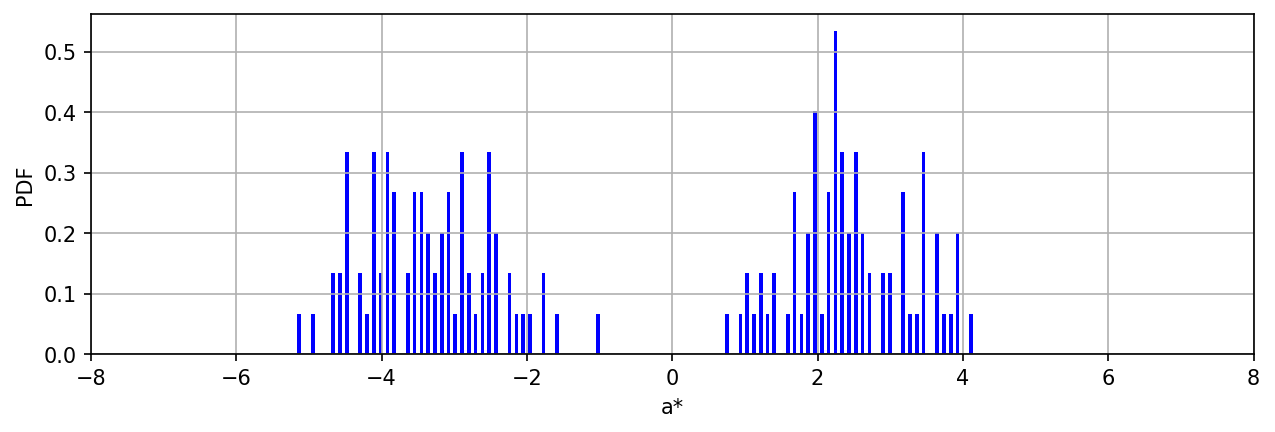

In [7]:
plt.figure(figsize = [10,3], dpi = 150)
plt.grid()
hist, bins = np.histogram(data[:,0,:].ravel(), bins = 100, normed = True)
plt.bar(bins[:-1], hist, width=0.05, color='b')
plt.ylabel("PDF")
plt.xlabel("a*")
plt.xlim(-8,8)


C:\Users\Rene\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


(-2, 22)

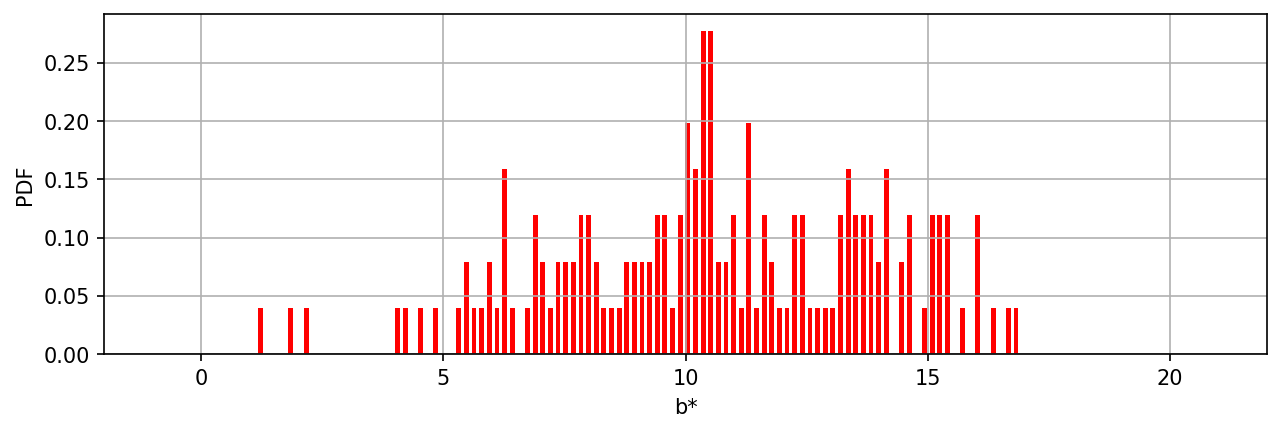

In [8]:
plt.figure(figsize = [10,3], dpi = 150)
plt.grid()
hist, bins = np.histogram(data[:,1,:].ravel(), bins = 100, normed = True)
plt.bar(bins[:-1], hist, width=0.10, color='r')
plt.ylabel("PDF")
plt.xlabel("b*")
plt.xlim(-2,22)


In [43]:
gmm = GMM(DATA)
gmm.fit()

Iteration 1: log-likelihood is -1130.405275
Iteration 2: log-likelihood is -956.857984
Iteration 3: log-likelihood is -956.704137
Iteration 4: log-likelihood is -956.469775
Iteration 5: log-likelihood is -955.977667
Iteration 6: log-likelihood is -954.611589
Iteration 7: log-likelihood is -951.187129
Iteration 8: log-likelihood is -946.393198
Iteration 9: log-likelihood is -942.396370
Iteration 10: log-likelihood is -939.316484
Iteration 11: log-likelihood is -936.834703
Iteration 12: log-likelihood is -934.346849
Iteration 13: log-likelihood is -930.254643
Iteration 14: log-likelihood is -919.444695
Iteration 15: log-likelihood is -888.560624
Iteration 16: log-likelihood is -857.349135
Iteration 17: log-likelihood is -845.846778
Iteration 18: log-likelihood is -836.691013
Iteration 19: log-likelihood is -828.401475
Iteration 20: log-likelihood is -814.110534
Iteration 21: log-likelihood is -811.916835
Iteration 22: log-likelihood is -811.912015
Iteration 23: log-likelihood is -811.912

In [46]:
mu = gmm.mean_arr
mu = np.array(mu)
mu

array([[ 2.48631363, 12.4981904 ],
       [-3.63040188,  8.85225659]])

In [45]:
sigma = gmm.sigma_arr
sigma

array([[[ 0.69449519, -0.36023079],
        [-0.36023079,  8.22599568]],

       [[ 0.98019737, -1.11414733],
        [-1.11414733,  4.43739046]]])

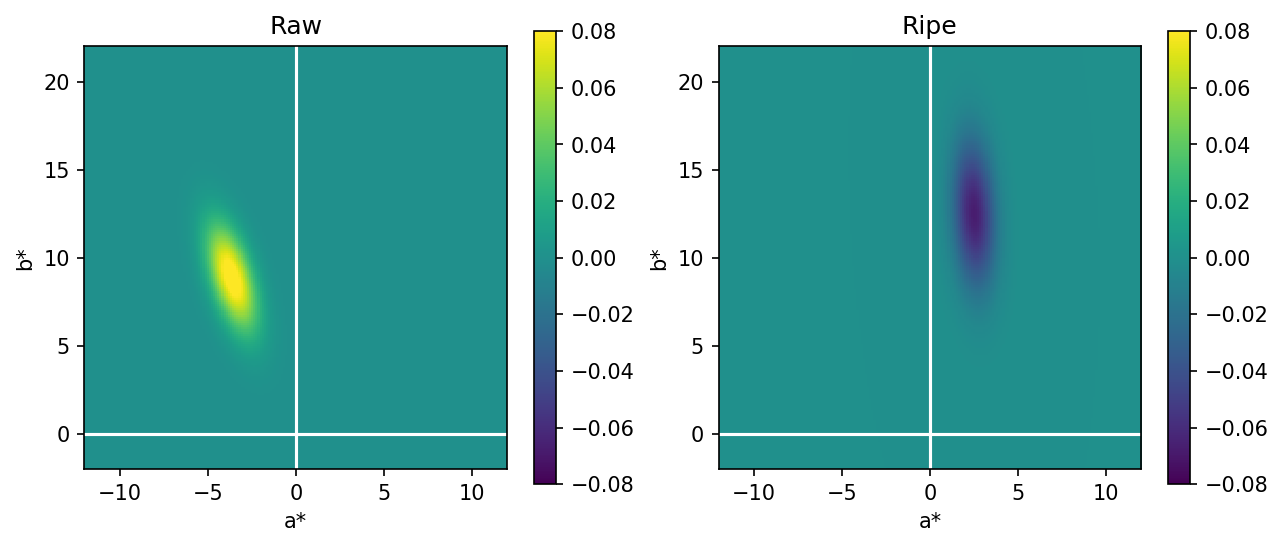

In [23]:
i = 0
X, Y = np.meshgrid(np.linspace(-12,12,200), np.linspace(-2,22,200))
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z1 = multivariate_gaussian(pos, mu[0], sigma[0])
Z2 = -(multivariate_gaussian(pos, mu[1], sigma[1]))

plt.figure(figsize = [10,4],dpi = 150)
plt.subplot(1,2,1)
plt.title("Raw")
plt.axvline(0, color = 'w')
plt.axhline(0, color = 'w')
plt.imshow(Z1, origin = 'lower',extent = [-12,12,-2,22])
plt.xlabel("a*")
plt.ylabel("b*")
plt.colorbar()
plt.clim(-0.08,0.08)

plt.subplot(1,2,2)
plt.title("Ripe")
plt.axvline(0, color = 'w')
plt.axhline(0, color = 'w')
plt.xlabel("a*")
plt.ylabel("b*")
plt.imshow(Z2, origin = 'lower',extent = [-12,12,-2,22])
plt.colorbar()
plt.clim(-0.08,0.08)


Text(0.5, 1.0, 'Mean color distribution in a*b* colorspace')

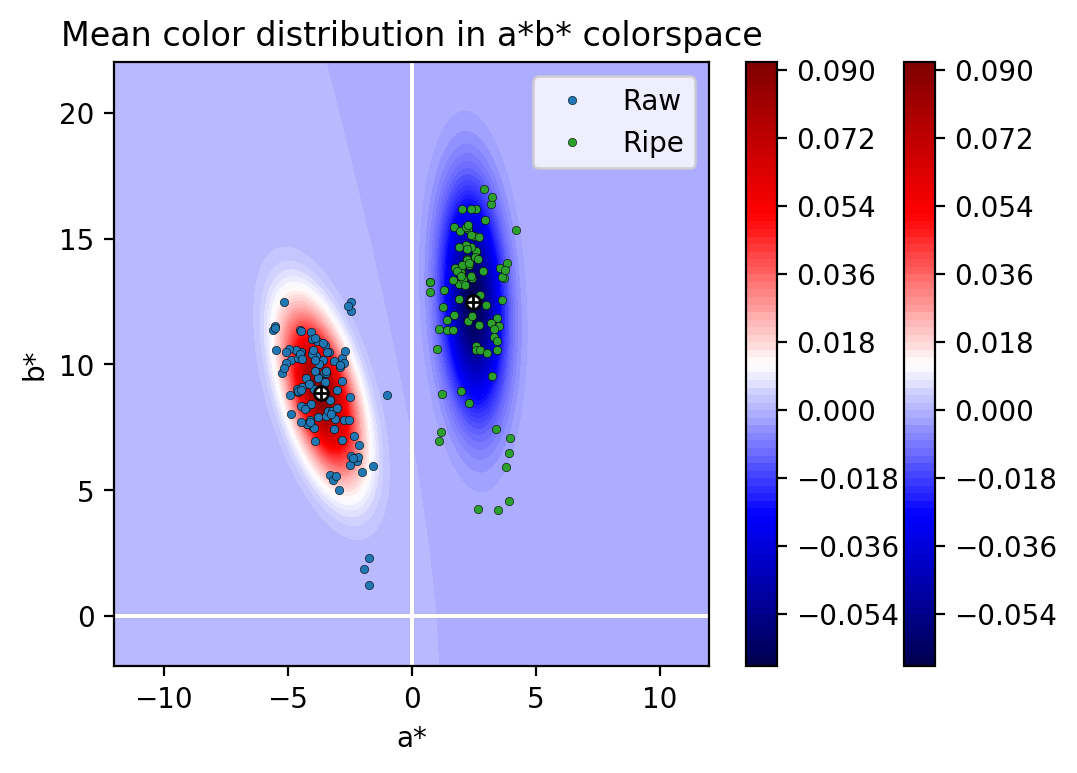

In [22]:
plt.figure(dpi=200)
plt.axhline(0, color = 'k')
plt.axvline(0, color = 'k')


for i in name:
    classs = name.index(i)
    a_, b_, hue = LAB_mean(i)

    mean[classs,0] = np.mean(a_)
    mean[classs,1] = np.mean(b_)
    plt.grid()

    #plt.imshow(Z1+Z2, origin = 'lower', extent = [-10,10,0,20])
    plt.plot(a_,b_,'o',ms = 3, mec = 'k', label = i, mew = 0.2)
    plt.plot(np.mean(a_),np.mean(b_), 'wo', ms= 5, mec = 'k')
    plt.plot(np.mean(a_),np.mean(b_), '+', ms= 5, mec = 'k')
    plt.contourf(X, Y, Z1+Z2, cmap='seismic', levels = 100)
    plt.colorbar()
    plt.xlabel("a*")
    plt.ylabel("b*")
    plt.axvline(0, color = 'w')
    plt.axhline(0, color = 'w')
    plt.xlim(-12,12)
    plt.ylim(-2,22)
    
plt.legend()
plt.title("Mean color distribution in a*b* colorspace")

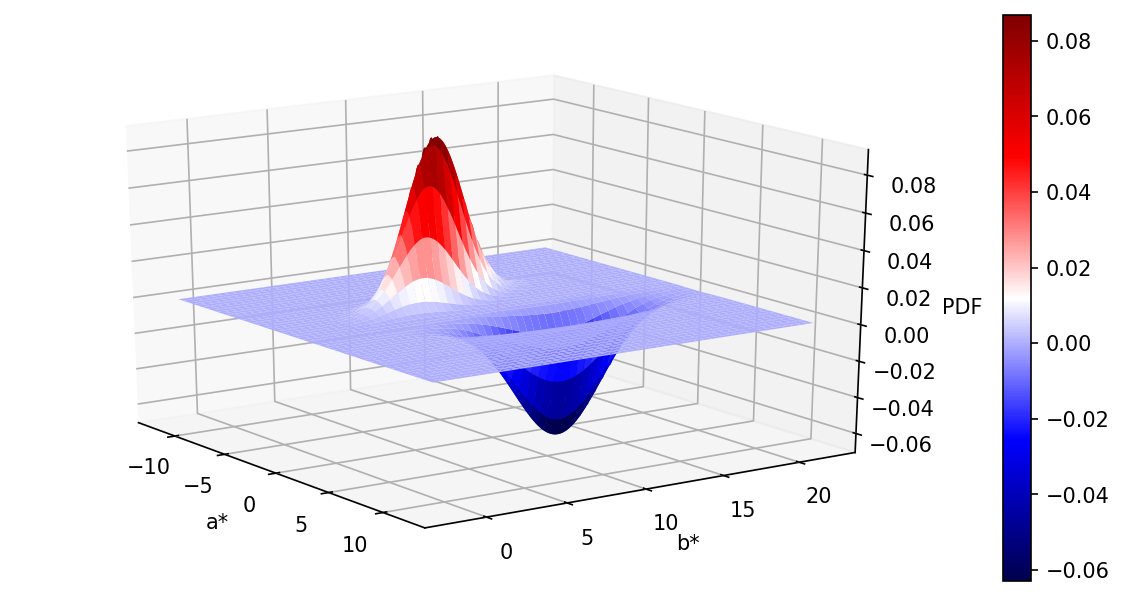

In [39]:
fig = plt.figure(figsize = [10,5], dpi = 150, facecolor = 'w')
ax = fig.add_subplot(111, projection='3d')
p = ax.plot_surface(X, Y, Z1+Z2, cmap = 'seismic')
ax.set_xlabel("a*")
ax.set_ylabel("b*")
ax.set_zlabel("PDF")
ax.view_init(azim=-35, elev = 20)
fig.colorbar(p)



In [29]:
help(ax.view_init)

Help on method view_init in module mpl_toolkits.mplot3d.axes3d:

view_init(elev=None, azim=None) method of matplotlib.axes._subplots.Axes3DSubplot instance
    Set the elevation and azimuth of the axes in degrees (not radians).
    
    This can be used to rotate the axes programmatically.
    
    'elev' stores the elevation angle in the z plane (in degrees).
    'azim' stores the azimuth angle in the x,y plane (in degrees).
    
    if elev or azim are None (default), then the initial value
    is used which was specified in the :class:`Axes3D` constructor.



In [14]:
n = 0
P = (1/(np.sqrt(det(COV[:,:,n])))*(2*np.pi))*(np.exp((-1/2 * ((data[:,:,n]-mean[:,n]))).dot(inv(COV[:,:,n])).dot((data[:,:,n]-mean[:,n]).T)))
P.shape

(80, 80)

In [18]:
P = np.matmul((data[:,:,n]-mean[:,n]).dot(inv(COV[:,:,n])),(data[:,:,n]-mean[:,n]).T)
P.shape


(80, 80)

In [28]:
((data[:,:,n]-mean[:,n])*(data[:,:,n]-mean[:,n])).shape

(80, 2)

In [39]:
 = data[:,:,n]-mean[:,n]
C = 

In [53]:
np.exp((-1/2) *inv(C).dot(X.T).dot(X))

array([[4.72656026e-027, 6.65003343e-297],
       [7.93526994e-011, 1.99353552e-247]])

Iteration 1: log-likelihood is -344.749184
Iteration 2: log-likelihood is -265.018172
Iteration 3: log-likelihood is -264.167773
Iteration 4: log-likelihood is -262.461062
Iteration 5: log-likelihood is -260.564912
Iteration 6: log-likelihood is -259.247184
Iteration 7: log-likelihood is -258.318864
Iteration 8: log-likelihood is -257.249228
Iteration 9: log-likelihood is -255.415507
Iteration 10: log-likelihood is -253.224118
Iteration 11: log-likelihood is -252.159387
Iteration 12: log-likelihood is -251.884530
Iteration 13: log-likelihood is -251.717379
Iteration 14: log-likelihood is -251.543776
Iteration 15: log-likelihood is -251.346740
Iteration 16: log-likelihood is -251.122700
Iteration 17: log-likelihood is -250.893216
Iteration 18: log-likelihood is -250.716163
Iteration 19: log-likelihood is -250.630468
Iteration 20: log-likelihood is -250.605069
Iteration 21: log-likelihood is -250.599632
Iteration 22: log-likelihood is -250.598631
Iteration 23: log-likelihood is -250.5984

In [91]:
mu1 = gmm.mean_arr


In [96]:
mu1

matrix([[-2.11746394,  6.80156526],
        [-3.4384195 ,  8.96510316]])

array([[[ 0.09979958, -1.38547277],
        [-1.38547277, 20.47092282]],

       [[ 0.63644238, -0.81795178],
        [-0.81795178,  3.07318472]]])

In [112]:


#zy = multivariate_gaussian(pos, np.array([-1.38547277, 20.47092282]), np.array([[ 0.63644238, -0.81795178],[-0.81795178,  3.07318472]]))


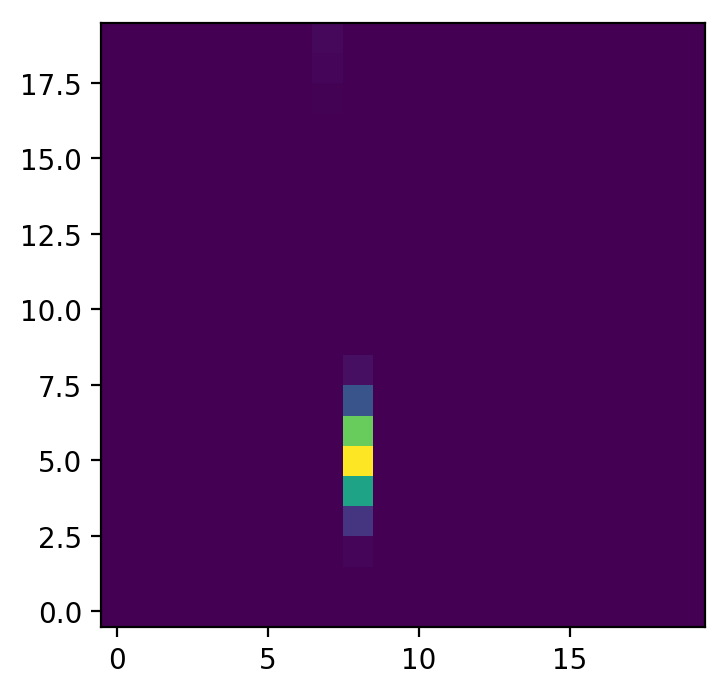

In [73]:
gmm.phi

array([0.10064085, 0.89935915])

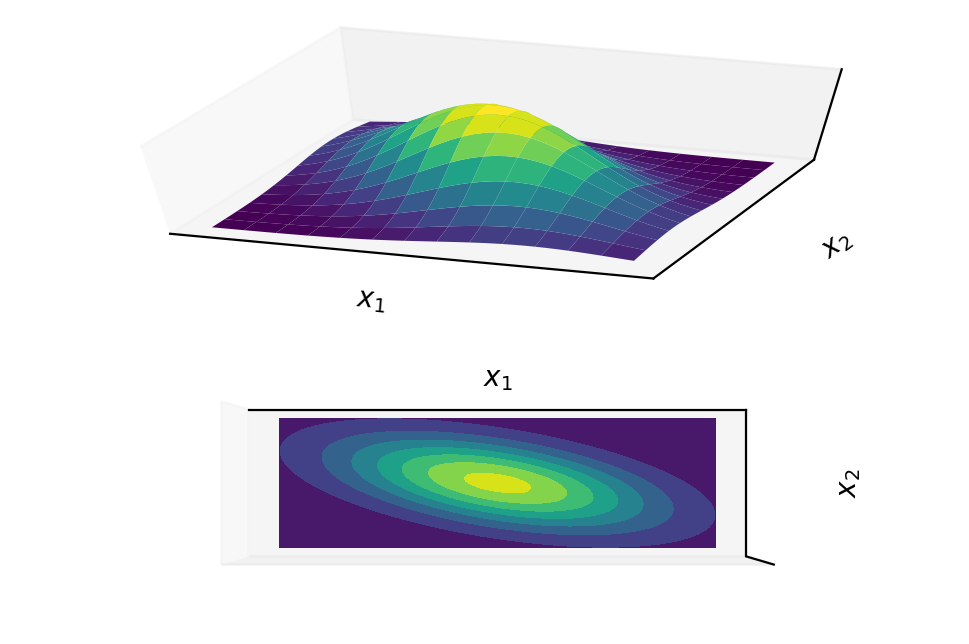

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Our 2-dimensional distribution will be over variables X and Y
N = 40
X = np.linspace(-2, 2, N)
Y = np.linspace(-2, 2, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 0.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.]])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y



# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)

# plot using subplots
fig = plt.figure(dpi = 200)
ax1 = fig.add_subplot(2,1,1,projection='3d')

ax1.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax1.view_init(55,-70)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2 = fig.add_subplot(2,1,2,projection='3d')
ax2.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.viridis)
ax2.view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')

plt.show()